In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Load the Dataset**

In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Path to the zip files in your Google Drive
zip_files = ['/content/drive/My Drive/inverted.zip']
             #'/content/drive/My Drive/LTO_captcha.zip']

# Path to extract the zip files
extract_path = '/content/'

for zip_file_path in zip_files:
    # Check if the zip file exists
    if os.path.exists(zip_file_path):
        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extraction of {zip_file_path} completed successfully.")
    else:
        print(f"The specified zip file {zip_file_path} does not exist in your Google Drive.")

Extraction of /content/drive/My Drive/inverted.zip completed successfully.


# **PREPROCESSING INFORMATION**

In [21]:
# Path to the data directory
data_dir = Path("/content/inverted")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Numbers of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size fot training and validation
batch_size = 16

# Desired image dimensions
img_width = 580
img_height = 160

# Factor by which the image is going to be downsampled
# by the convulational blocks. We will be using two
# convulation blocks and each block will have
# 3 pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  5445
Number of labels found:  5445
Numbers of unique characters:  37
Characters present:  {'Z', 'D', 'F', 'H', '2', 'I', '7', '1', '4', 'G', 'K', 'U', '0', 'Y', 'V', 'T', '9', '8', 'J', 'L', 'M', 'Q', 'R', 'C', 'E', 'B', '6', 'S', 'X', 'N', 'A', 'W', 'P', '5', '3', 'v', 'O'}


In [22]:
from PIL import Image
import os

for filename in os.listdir(data_dir):
    if filename.endswith('.jpeg'):
        # Construct the full path to the image
        filepath = os.path.join(data_dir, filename)

        # Open the image and print its width and height
        with Image.open(filepath) as img:
            if img.width != img_width or img.height != img_height:
                print(f'{filename}: Width = {img.width}, Height = {img.height}')

print(f'{labels=}')

different_sized_labels = [label for label in labels if len(label) != max_length]
print(f'{different_sized_labels=}')

assert len(different_sized_labels) == 0

labels=['102Q9', '10FHP', '10FYH', '10IJ1', '10INV', '11J98', '11LFH', '11P6P', '11RYL', '122C9', '12VL7', '1376C', '13C5Q', '13S5S', '13TTX', '141UF', '14CZT', '14RMA', '14T3F', '14UDF', '14V41', '15HHP', '15W9P', '15YWN', '166YC', '167PE', '177GV', '17VVF', '17XTQ', '17Z2P', '184I7', '1866U', '18995', '18LPG', '18QGG', '18WVI', '195QF', '198J2', '19BW7', '19CZG', '19GDI', '19TPI', '1A80R', '1AG1L', '1AHUD', '1AWH3', '1AYV2', '1B3U4', '1B5R5', '1B6BG', '1B6T4', '1BAZZ', '1BX6J', '1CCVP', '1CPDC', '1CRB8', '1CT52', '1CWGK', '1D4NW', '1D56U', '1D7PK', '1D9QA', '1DA50', '1DETK', '1DHTA', '1DL4S', '1DV1Y', '1DZ1R', '1E3YC', '1E45G', '1EIXZ', '1ESVK', '1ETA1', '1ETN7', '1EYC3', '1FCY9', '1FFBA', '1FHVQ', '1G2VA', '1GSVH', '1H671', '1HIN7', '1HJLZ', '1HRBX', '1I2IZ', '1I9FU', '1I9X6', '1IDLC', '1JEWK', '1JHCD', '1JII7', '1K2HH', '1K3DP', '1K77H', '1KBE4', '1L22U', '1L2Q2', '1LE8A', '1LT70', '1LUZA', '1M1NL', '1M3H9', '1M3KS', '1MP2P', '1MTZI', '1N6R0', '1N7BT', '1NA4P', '1NCUE', '1NFXP', '1

# **PREPROCESSING THE DATA**

In [23]:
# Mapping characters to integers
#char_to_num = layers.experimental.preprocessing.StringLookup(
    #vocabulary=list(characters), num_oov_indices=0, mask_token=None
#)
# Char to integers
char_to_num = layers.StringLookup(
	vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characteres
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def split_data(images, labels, train_size=0.9, shuffle=True):
  # 1. Get the total size of the dataset
  size = len(images)
  # 2. Make an indices array and shuffle it, if required
  indices = np.arange(size)
  if shuffle:
    np.random.shuffle(indices)
  # 3. Get the size of training samples
  train_samples = int(size * train_size)
  # 4. Split data into training and validation sets
  x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
  x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
  return x_train, x_valid, y_train, y_valid

# Splitting data intro training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # Read image
    img = tf.io.read_file(img_path)
    # Decode image
    img = tf.io.decode_jpeg(img, channels=3)  # Decode with 3 channels for color images
    # Invert colors
    img = 1 - img  # Inversion by subtracting pixel values from 1
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Convert to grayscale
    img = tf.image.rgb_to_grayscale(img)  # Convert to grayscale
    # Transpose the image because we want the time dimension to correspond to the width of the image
    img = tf.transpose(img, perm=[1, 0, 2])
    # Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # Return a dictionary containing the image and its label
    return {"image": img, "label": label}

# **Create Dataset Objects**

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# **Visualize the Data**

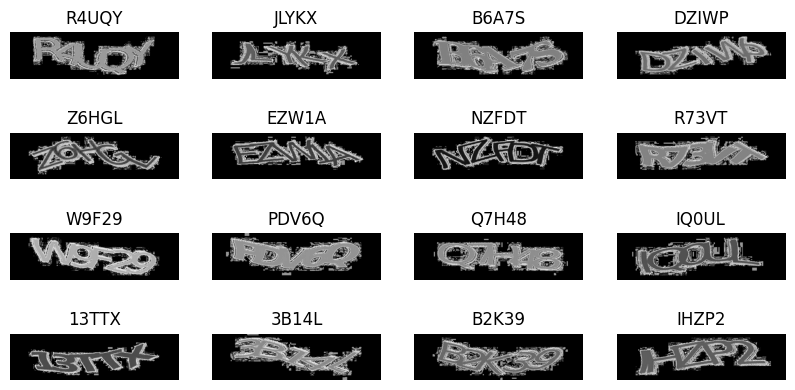

In [25]:
#_, ax = plt.subplots(4, 4, figsize=(10, 5))
#for batch in train_dataset.take(1):
  #images = batch["image"]
  #labels = batch ["label"]
  #for i in range(16):
    #img = (images[i] * 255).numpy().astype("uint8")
    #label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    #ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap ="gray")
    #ax[i // 4, i % 4].set_title(label)
    #ax[i // 4, i % 4].axis("off")
#plt.show()

# Visualizing some training data
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
	dir_img = batch["image"]
	img_labels = batch["label"]
	for i in range(16):
		img = (dir_img[i] * 255).numpy().astype("uint8")
		label = tf.strings.reduce_join(num_to_char(
			img_labels[i])).numpy().decode("utf-8")
		ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
		ax[i // 4, i % 4].set_title(label)
		ax[i // 4, i % 4].axis("off")
plt.show()


# **Create the OCR Model (New | DO NOT USE)**

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
      super().__init__(name=name)
      self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
      # Compute the training-time loss value and add it
      # to the layer using 'self.add_loss()'.
      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      input_ength = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

      loss = self.loss_fn(y_true, y_pred, input_length, label_length)
      self.add_loss(loss)

      # At test time, just return the computed predictions
      return y_pred

def build_model():
  # Inputs to the model
  input_img = layers.Input(
      shape=(img_width, img_height, 1), name="image", dtype="float32"
  )
  labels = layers.Input(name="label", shape=(None,), dtype="float32")

  # First conv block
  x = layers.Conv2D(
      32,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1",
  )(input_img)
  x = layers.MaxPooling2D((2, 2), name="pool1")(x)

  # Second conv block
  x = layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv2",
  )(x)
  x = layers.MaxPooling2D((2, 2), name="pool2")(x)

  # We have used two max pool with pool size and strides 2.
  # Hence, downsampled feature maps are 4x smaller. The number of
  # filters in the last layer is 64. Reshape accordingly before
  # passing the output to the RNN part of the model
  new_shape = ((img_width // 4), (img_height // 4) * 64)
  x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = layers.Dense(64, activation="relu", name="dense1")(x)
  x = layers.Dropout(0.2)(x)

  # RNNs
  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

  # Output layer
  x = layers.Dense(len(characters) +1, activation="softmax", name="dense2")(x)

  # Add CTC layer for calculating CTC loss at each step
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model
  model = keras.models.Model(
      inputs=[inputs_img, labels], outputs=output, name="ocr_model_v1"
  )
  # Optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and reutnr
  model.compile(optimizer=opt)
  return model

# Get the model
model = build_model()
model.summary()



ValueError: Exception encountered when calling layer "ctc_loss" (type CTCLayer).

in user code:

    File "<ipython-input-9-14cc269438f5>", line 16, in call  *
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 7159, in ctc_batch_cost
        input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)

    ValueError: squeeze_dims[0] not in [0,0). for '{{node ctc_loss/Squeeze_1}} = Squeeze[T=DT_INT64, squeeze_dims=[-1]](ctc_loss/Cast_1)' with input shapes: [].


Call arguments received by layer "ctc_loss" (type CTCLayer):
  • y_true=tf.Tensor(shape=(None, None), dtype=float32)
  • y_pred=tf.Tensor(shape=(None, 145, 38), dtype=float32)

# **Create the OCR Model (Original)**

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM
import keras

# Define LayerCTC class and register it for serialization
@tf.keras.utils.register_keras_serializable()
class LayerCTC(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Return computed predictions
        return y_pred


def model_build(img_width, img_height):
    # Define the inputs to the model
    input_img = Input(shape=(img_width, img_height, 1), name="image", dtype="float32")  # Added input layer for image
    img_labels = Input(name="label", shape=(None,), dtype="float32")  # Added input layer for labels

    # First convolutional block
    x = Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second convolutional block
    x = Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # Reshaping the output before passing to RNN
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNNs
    x = Bidirectional(LSTM(
        128, return_sequences=True, dropout=0.25))(x)
    x = Bidirectional(LSTM(
        64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = Dense(
        len(char_to_num.get_vocabulary()) + 1,
        activation="softmax", name="dense2"
    )(x)

    # Calculate CTC loss at each step
    output = LayerCTC(name="ctc_loss")(img_labels, x)

    # Defining the model with two inputs
    model = Model(
        inputs=[input_img, img_labels],
        outputs=output,
        name="ocr_model_v1"
    )
    opt = keras.optimizers.Adam()

    # Compile the model
    model.compile(optimizer=opt)

    return model

# Build the model with specified image dimensions
model = model_build(img_width=580, img_height=160)
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 580, 160, 1)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 580, 160, 32)         320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 290, 80, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 290, 80, 64)          18496     ['pool1[0][0]']               
                                                                                       

# **Train the Neural Network**

In [28]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
307/307 [==============================] - 22s 46ms/step - loss: 32.1782 - val_loss: 19.5240
Epoch 2/100
307/307 [==============================] - 13s 42ms/step - loss: 19.5227 - val_loss: 19.4757
Epoch 3/100
307/307 [==============================] - 13s 42ms/step - loss: 19.1467 - val_loss: 18.7437
Epoch 4/100
307/307 [==============================] - 13s 41ms/step - loss: 18.7780 - val_loss: 18.6589
Epoch 5/100
307/307 [==============================] - 13s 41ms/step - loss: 18.7037 - val_loss: 18.6245
Epoch 6/100
307/307 [==============================] - 13s 41ms/step - loss: 18.6590 - val_loss: 18.6036
Epoch 7/100
307/307 [==============================] - 13s 42ms/step - loss: 18.6356 - val_loss: 18.5920
Epoch 8/100
307/307 [==============================] - 13s 41ms/step - loss: 18.6137 - val_loss: 18.5774
Epoch 9/100
307/307 [==============================] - 13s 41ms/step - loss: 18.5944 - val_loss: 18.5494
Epoch 10/100
307/307 [==============================] -

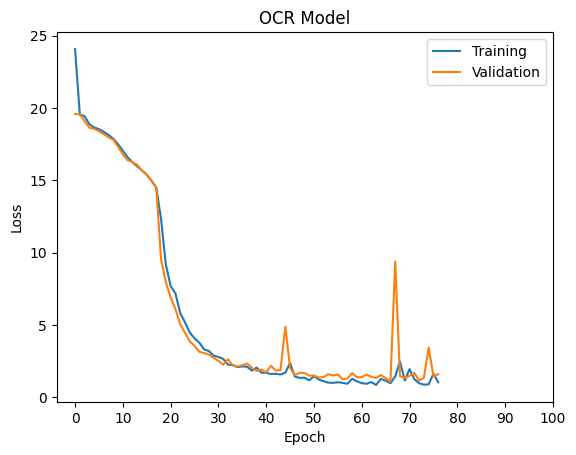

In [13]:
# Plot the loss of the model during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0,epochs+1,10))
plt.title("OCR Model")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# **Predictions with Trained Neural Network (Original)**

1/1 [==============================] - 0s 35ms/step


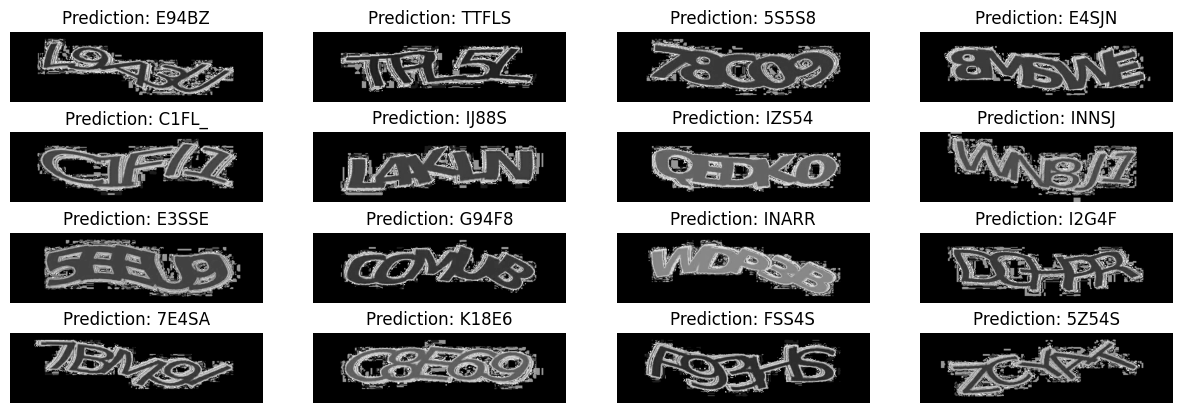

In [29]:
# Check the validation on a few samples
for batch in validation_dataset.take(1):
	batch_images = batch["image"]
	batch_labels = batch["label"]


	preds = prediction_model.predict(batch_images)
	pred_texts = decode_batch_predictions(preds)


	orig_texts = []
	for label in batch_labels:
		label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
		orig_texts.append(label)


	_, ax = plt.subplots(4, 4, figsize=(15, 5))
	for i in range(len(pred_texts)):
		img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
		img = img.T
		title = f"Prediction: {pred_texts[i]}".replace('[UNK]', '_')
		ax[i // 4, i % 4].imshow(img, cmap="gray")
		ax[i // 4, i % 4].set_title(title)
		ax[i // 4, i % 4].axis("off")
plt.show()


# **Predictions with Trained Neural Network (New)**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 580, 160, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 580, 160, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 290, 80, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 290, 80, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 145, 40, 64)       0         
                                                                 
 reshape (Reshape)           (None, 145, 2560)         0         
                                                                 
 dense1 (Dense)              (None, 145, 64)           1639

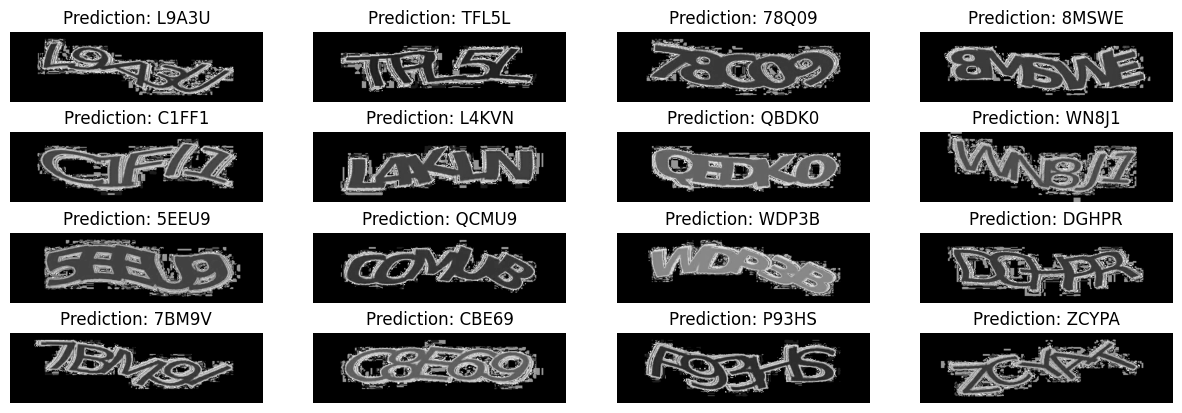

In [30]:
# Get the prediction model by extracting layers till output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


# Let's check results on some validation samples
for batch in validation_dataset.take(1):
  batch_images = batch["image"]
  batch_labels = batch["label"]

  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)

  orig_texts = []
  for label in batch_labels:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    orig_texts.append(label)

  _, ax = plt.subplots(4, 4, figsize=(15, 5))
  for i in range(len(pred_texts)):
    img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T
    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

# **Save the Model**

In [44]:
# Save the model
#model.save('ocr_model.keras')

In [32]:
# Save the prediction model
prediction_model.save('ocr_model.keras')

# **Single Image Prediction (IN PROGRESS | DO NOT USE)**

In [1]:


# Load the OCR model
ocr_model = load_model("/content/ocr_model.keras")

# Path to the single image
image_path = '/content/1B3U4.jpg'

# Predict text from the single image
predicted_text = predict_single_image(image_path)
print("Predicted Text:", predicted_text)



NameError: name 'load_model' is not defined